In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os, shutil, glob, sys, math, cv2
import pydicom

import segmentation_models_pytorch as smp
import albumentations as albu
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [2]:
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from collections import OrderedDict
from torch.utils.model_zoo import load_url as load_state_dict_from_url
from torch import Tensor
from torch.jit.annotations import List
from torchsummary import summary
from torchvision import models

import segmentation_models_pytorch as smp
import albumentations as albu

In [3]:
train_dicom_folder = '/work/tsung1271232/ncku-dataset/train/dicom'
train_label_folder = '/work/tsung1271232/ncku-dataset/train/label'
valid_dicom_folder = '/work/tsung1271232/ncku-dataset/test/dicom'
valid_label_folder = '/work/tsung1271232/ncku-dataset/test/label'
normal_folder = '/work/tsung1271232/ncku-dataset/normal'
init_seg_folder = '/work/tsung1271232/ncku-dataset/init_seg'

In [4]:
# ncku segmentation data
train_dicom_fp = []
train_label_fp = []
valid_dicom_fp = []
valid_label_fp = []
for i in sorted(os.listdir(train_dicom_folder)):
    name, extension = os.path.splitext(i)
    train_dicom_fp.append(os.path.join(train_dicom_folder, i))
    if os.path.exists(os.path.join(train_label_folder, name, 'label.png')):
        train_label_fp.append(os.path.join(train_label_folder, name, 'label.png'))
    else:
        train_label_fp.append(None)
        
for i in sorted(os.listdir(valid_dicom_folder)):
    name, extension = os.path.splitext(i)
    valid_dicom_fp.append(os.path.join(valid_dicom_folder, i))
    if os.path.exists(os.path.join(valid_label_folder, name, 'label.png')):
        valid_label_fp.append(os.path.join(valid_label_folder, name, 'label.png'))
    else:
        valid_label_fp.append(None)
print(len(train_dicom_fp), len(train_label_fp), len(valid_dicom_fp), len(valid_label_fp))

1656 1656 415 415


In [5]:
# 73 normal data
from sklearn.model_selection import train_test_split
normal = sorted(os.listdir(normal_folder))
train_normal, valid_normal = train_test_split(normal, test_size=0.33, random_state=42)
print(len(train_normal), len(valid_normal))
for i in train_normal:
    train_dicom_fp.append(os.path.join(normal_folder, i))
    train_label_fp.append(None)

for i in valid_normal:
    valid_dicom_fp.append(os.path.join(normal_folder, i))
    valid_label_fp.append(None)

1340 661


In [6]:
train_dicom_fp = np.array(train_dicom_fp)
train_label_fp = np.array(train_label_fp)
valid_dicom_fp = np.array(valid_dicom_fp)
valid_label_fp = np.array(valid_label_fp)
print('None:', len(np.where(train_label_fp == None)[0]), len(np.where(valid_label_fp == None)[0]))
print(len(train_dicom_fp), len(train_label_fp), len(valid_dicom_fp), len(valid_label_fp) )

None: 1611 729
2996 2996 1076 1076


In [7]:
for fp in train_dicom_fp:
    fp = os.path.split(fp)
    name, extension = os.path.splitext(fp[-1])
    init_seg_name = os.path.join(init_seg_folder, name+".npy")
    if not os.path.exists(init_seg_name):
        print(init_seg_name)

# Dataloader

In [8]:
def image_mask_preprocessing(image, mask, height = 1024, width = 1024, **kwargs):
    larger_side = max(image.shape[0], image.shape[1])
    
    aug = albu.Compose([
        albu.PadIfNeeded(min_height=larger_side, min_width=larger_side, always_apply=True, border_mode=0),
        albu.Resize(height=height, width=width , always_apply=True,)
    ])
    
    sample = aug(image=image, mask=mask)
    image, mask = sample['image'], sample['mask']
    
    # normalize
    image = (image - image.min()) / (image.max() - image.min()) * (255 - 0) + 0
    image = image.astype('uint8')
    
    mask = np.where(mask > 0, 1, 0)
    # convert to 3 channel
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image, mask

In [9]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

class Dataset(BaseDataset):
    def __init__(
            self, 
            images_fps, 
            masks_fps, 
            augmentation=None, 
            preprocessing=None,
            **kwargs,
    ):
        self.images_fps = images_fps
        self.masks_fps = masks_fps
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.kwargs = kwargs
    
    def __getitem__(self, i):
        # dicom
        dcm = pydicom.dcmread(self.images_fps[i])
        image = dcm.pixel_array
        # init seg 1024x1024
        fp = os.path.split(self.images_fps[i])
        name, extension = os.path.splitext(fp[-1])
        init_seg_name = os.path.join(init_seg_folder, name+".npy")
        mask = np.load(init_seg_name)
        mask = mask.astype('float')
        
        if(self.masks_fps[i] == None):
            cls = 0
        else:
            cls = 1
        image, no_use = image_mask_preprocessing(image, np.zeros_like(image), **self.kwargs)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        mask = np.expand_dims(mask, axis=-1)
        new_image = np.concatenate((image, mask), axis = -1)
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=new_image)
            new_image = sample['image']
        
        return new_image, cls
    
    def __len__(self):
        return len(self.images_fps)

In [10]:
# train_dataset = Dataset(
#     train_dicom_fp, 
#     train_label_fp, 
#     augmentation=get_training_augmentation(),
#     preprocessing=get_preprocessing(),
#     height = 1024,
#     width = 1024
# )

# train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=16)


In [11]:
# for i in train_loader:
#     image, cls = i
#     print(image.shape, cls.shape)
#     break

In [12]:
# for i in range(len(train_dataset)):
#     image, cls = train_dataset[i]
#     print(image.shape)
#     temp_image = image[:,:,:3]
#     temp_mask = image[:,:,3]
#     print(temp_image.shape, temp_mask.shape)
#     plt.figure(figsize=(6,6))
#     plt.subplot(1,2,1)
#     plt.imshow(temp_image.astype('uint8'))
#     plt.subplot(1,2,2)
#     plt.imshow(temp_mask)
#     print(cls)
#     break

# augmentation

In [10]:
def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=10, shift_limit=0.1, p=0.3, border_mode=0),
        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),
        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),
        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),
        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing():
    _transform = [
        # albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image= to_tensor)
    ]
    return albu.Compose(_transform)

def model_data_preprocessing(image):
    image = image.astype('uint8')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = to_tensor(image)
    return image

# loss

In [11]:
import utils.metrics

# model setting

In [12]:
model_arch = 'res2net5026w4s'
epoch = 60
batch_size = 8
loss_fun = 'CE'

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [17]:
import models.res2net as res2net

model = res2net.res2net50(pretrained=True)
model.conv1 = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2,2), padding=(3,3))
model.fc = nn.Linear(2048, 2)
print(model)

Res2Net(
  (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottle2neck(
      (conv1): Conv2d(64, 104, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(104, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pool): AvgPool2d(kernel_size=3, stride=1, padding=1)
      (convs): ModuleList(
        (0): Conv2d(26, 26, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): Conv2d(26, 26, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (2): Conv2d(26, 26, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (bns): ModuleList(
        (0): BatchNorm2d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [18]:
import torch.optim.lr_scheduler

# model settings
loss = utils.metrics.CrossEntropy()

metrics = [
    utils.metrics.Fscore(),
    utils.metrics.Specificity()
]
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=1e-4),
])

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer = optimizer, eta_min=1e-6, T_max=30)

use_cuda = torch.cuda.is_available()
DEVICE = torch.device("cuda:0" if use_cuda else "cpu")

train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [14]:
# data settings
train_dataset = Dataset(
    train_dicom_fp, 
    train_label_fp, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(),
    height = 1024,
    width = 1024
)
valid_dataset = Dataset(
    valid_dicom_fp, 
    valid_label_fp, 
    preprocessing=get_preprocessing(),
    height = 1024,
    width = 1024
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=16)


In [ ]:
import time
import warnings
warnings.filterwarnings('ignore')

current_time = time.strftime("%Y_%m_%d_%H_%M", time.localtime())

model_folder_name = '/home/tsung1271232/pneumothorax-segmentation/weight/'
model_name = model_folder_name + str(current_time) + "{}_{}_bs:{}".format('cls', model_arch, batch_size)

max_score = 0

for i in range(0, epoch):
    print('\nEpoch: {}, batch: {}'.format(i, batch_size))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    lr_scheduler.step()
    if max_score < valid_logs['fscore']:
        max_score = valid_logs['fscore']
        torch.save(model.state_dict(), model_name+"_epoch:{}_fscore:{:.3f}.pth".format(i, max_score))
        print('Model saved! {}'.format(model_name+"_epoch:{}_fscore:{:.3f}.pth".format(i, max_score)))


Epoch: 0, batch: 8
valid: 100%|██████████| 135/135 [00:55<00:00,  2.43it/s, cross entropy - 1.568, fscore - 0.9919, specificity - 0.3831]
Model saved! /home/tsung1271232/pneumothorax-segmentation/weight/2020_09_13_18_33cls_res2net5026w4s_bs:8_epoch:0_fscore:0.992.pth

Epoch: 1, batch: 8
valid: 100%|██████████| 135/135 [00:55<00:00,  2.44it/s, cross entropy - 0.03264, fscore - 0.995, specificity - 1.0] 
Model saved! /home/tsung1271232/pneumothorax-segmentation/weight/2020_09_13_18_33cls_res2net5026w4s_bs:8_epoch:1_fscore:0.995.pth

Epoch: 2, batch: 8
valid: 100%|██████████| 135/135 [00:54<00:00,  2.46it/s, cross entropy - 0.0493, fscore - 0.994, specificity - 0.9991]  

Epoch: 3, batch: 8
valid: 100%|██████████| 135/135 [00:54<00:00,  2.47it/s, cross entropy - 0.02737, fscore - 0.9985, specificity - 0.9963]
Model saved! /home/tsung1271232/pneumothorax-segmentation/weight/2020_09_13_18_33cls_res2net5026w4s_bs:8_epoch:3_fscore:0.999.pth

Epoch: 4, batch: 8
valid: 100%|██████████| 135/135

# testing

In [15]:
import models.res2net as res2net

model = res2net.res2net50(pretrained=True)
model.conv1 = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2,2), padding=(3,3))
model.fc = nn.Linear(2048, 2)

model.load_state_dict(torch.load('/home/tsung1271232/pneumothorax-segmentation/weight/2020_09_13_18_33cls_res2net5026w4s_bs:8_epoch:6_fscore:0.999.pth'))
model.cuda()

Res2Net(
  (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottle2neck(
      (conv1): Conv2d(64, 104, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(104, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pool): AvgPool2d(kernel_size=3, stride=1, padding=1)
      (convs): ModuleList(
        (0): Conv2d(26, 26, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): Conv2d(26, 26, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (2): Conv2d(26, 26, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (bns): ModuleList(
        (0): BatchNorm2d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [16]:
cmap_no_background = LinearSegmentedColormap.from_list("", ["none", "blue", 'cyan', 'green', 'yellow', 'red'])
cmap_gt_background2 = LinearSegmentedColormap.from_list("", ["none", 'yellow'])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688


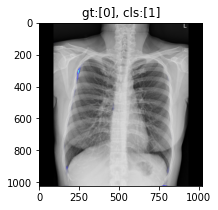

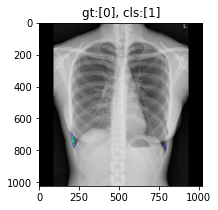

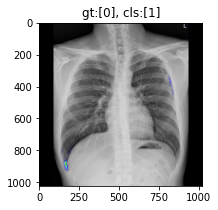

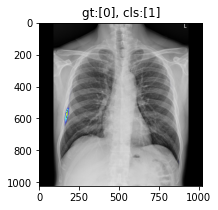

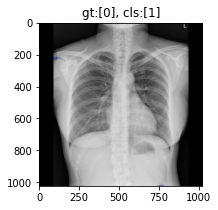

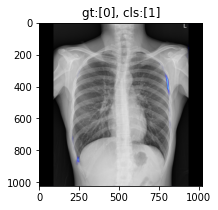

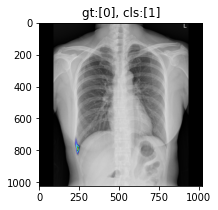

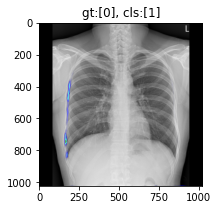

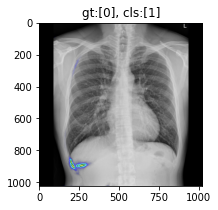

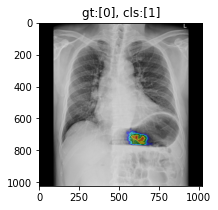

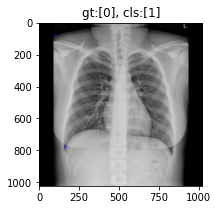

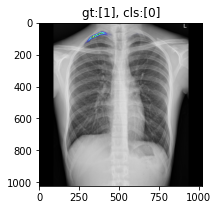

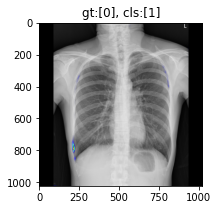

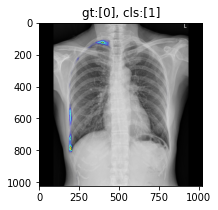

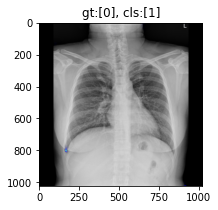

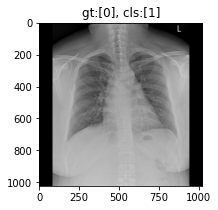

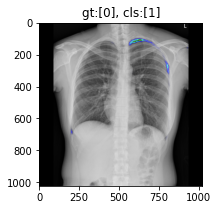

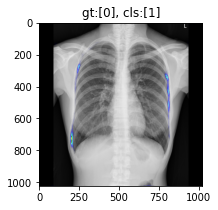

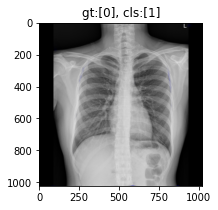

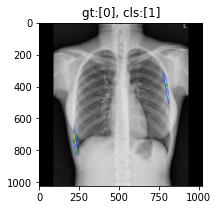

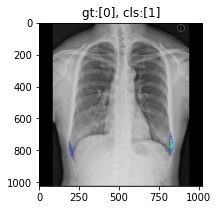

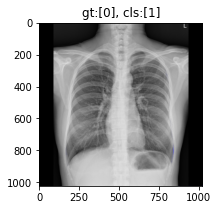

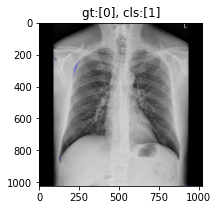

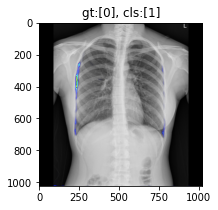

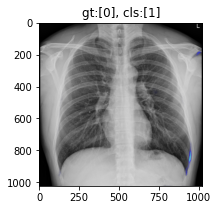

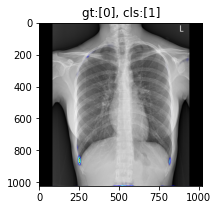

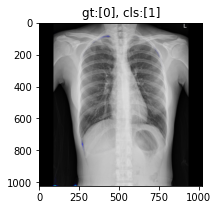

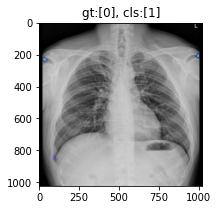

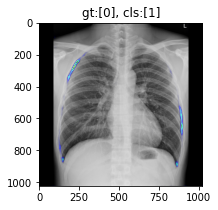

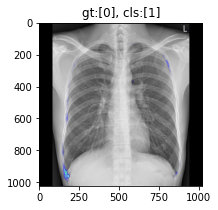

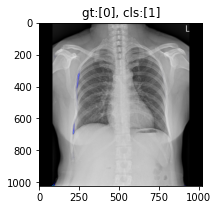

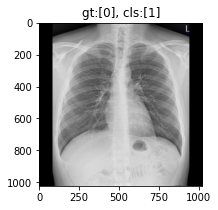

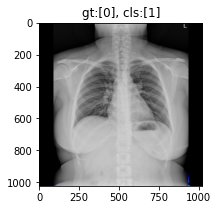

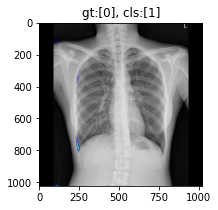

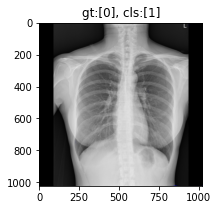

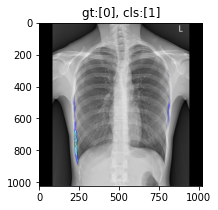

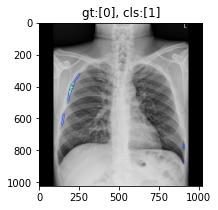

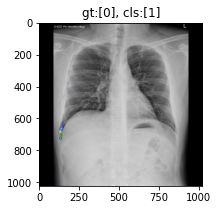

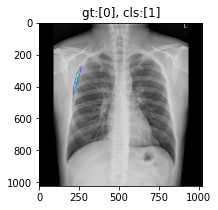

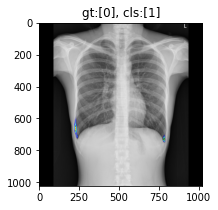

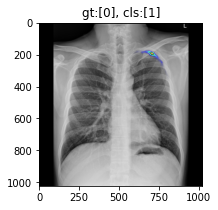

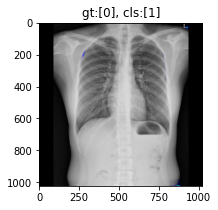

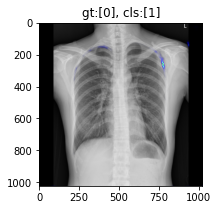

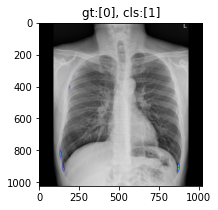

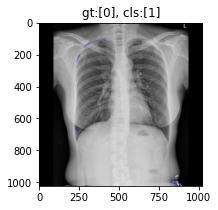

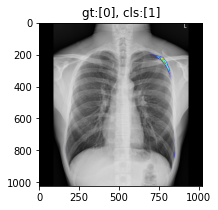

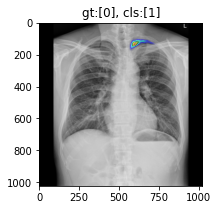

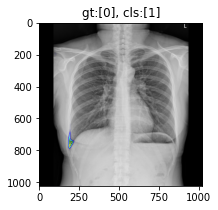

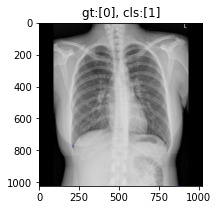

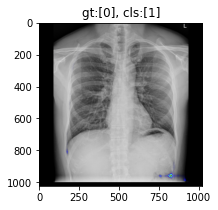

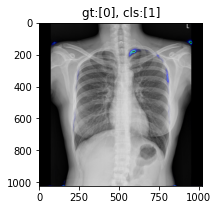

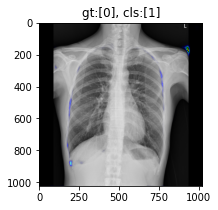

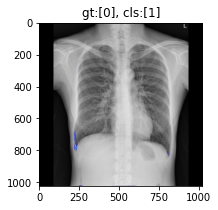

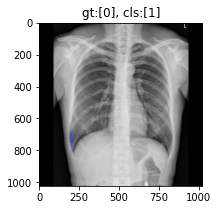

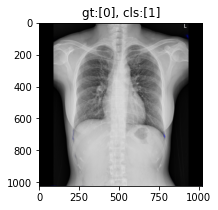

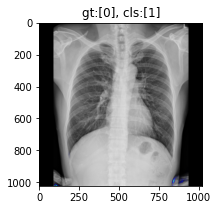

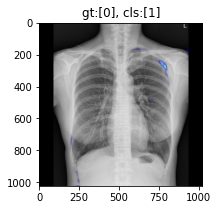

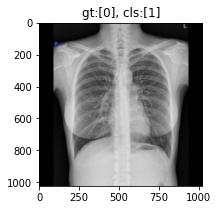

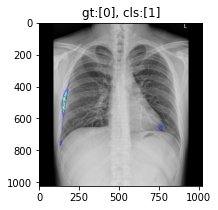

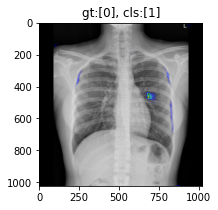

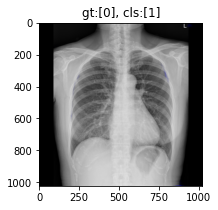

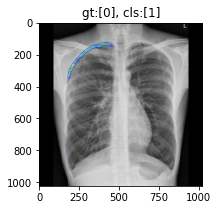

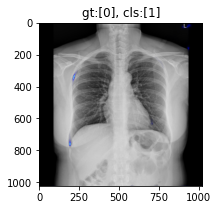

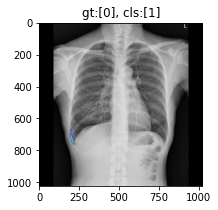

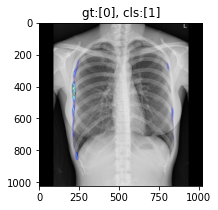

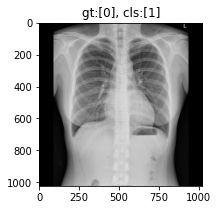

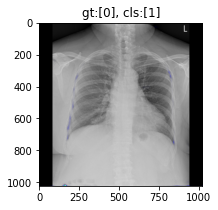

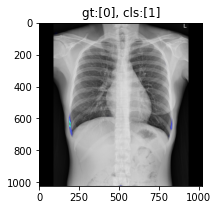

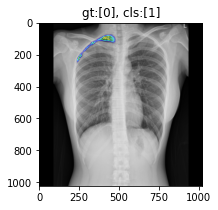

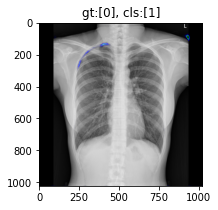

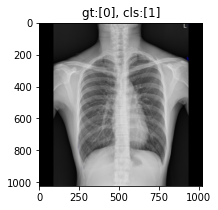

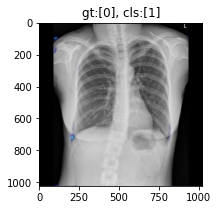

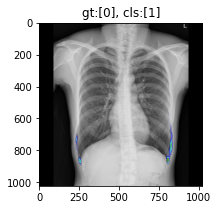

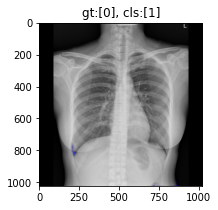

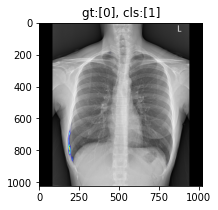

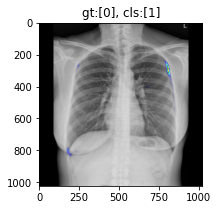

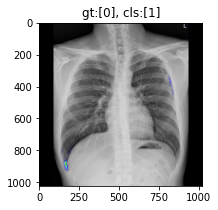

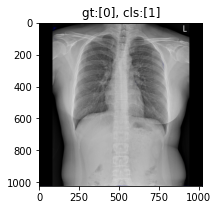

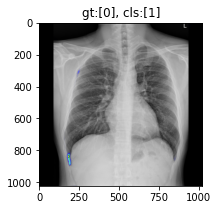

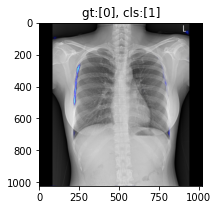

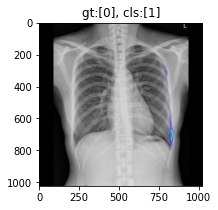

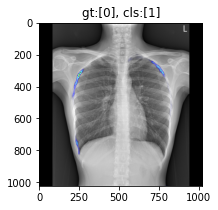

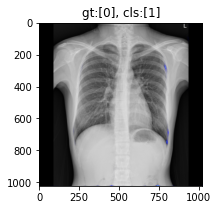

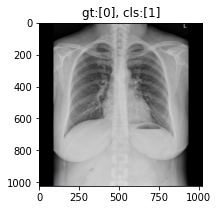

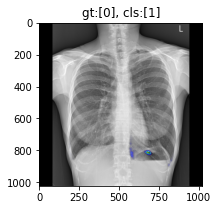

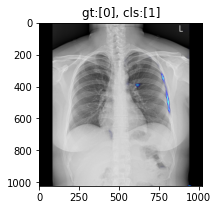

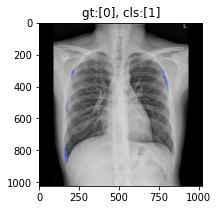

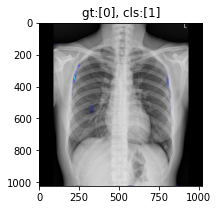

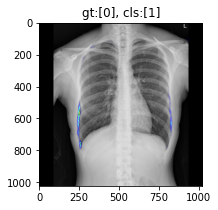

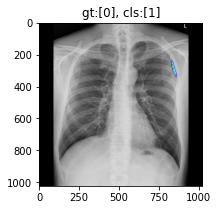

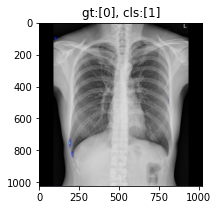

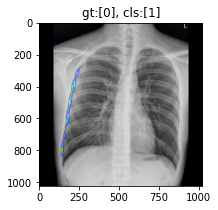

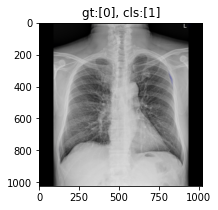

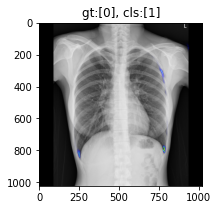

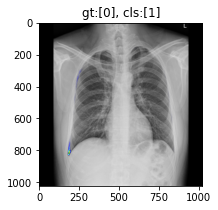

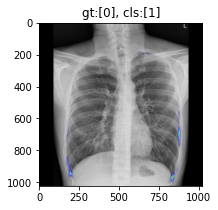

In [18]:
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)
error = []
idx = 0 
for i in valid_loader:
    print(idx)
    image, gt = i
    with torch.no_grad():
        cls = model(image.to('cuda'))
    cls = torch.softmax(cls, dim=1)
    cls = cls.detach().cpu().numpy()
    cls = np.argmax(cls, axis=1)
    
    gt = gt.detach().cpu().numpy()
    
    image = image.detach().cpu().numpy()
    image = np.squeeze(image)
    image = image.transpose(1,2,0)
    img = image[:, :, :3].astype('uint8')
    mask = image[:, :, 3]
    
    if(gt != cls):
        error.append(idx)
        plt.figure(figsize=(3,3))
        plt.title("gt:{}, cls:{}".format(gt, cls))
        plt.imshow(img, cmap="gray")
        plt.imshow(mask, alpha=0.5, cmap = cmap_no_background)
    idx += 1
    

In [20]:
len(error)

117

In [23]:
# del model
torch.cuda.empty_cache()

In [ ]:
for i in error:
    image, gt = valid_dataset[i]
    print(image.shape, gt)
    image = image.transpose(1,2,0)
    
    img = image[:, :, :3].astype('uint8')
    mask = image[:, :, 3]
    
    plt.figure(figsize=(3,3))
    plt.title("gt:{}".format(gt))
    plt.imshow(img, cmap="gray")
    plt.imshow(mask, alpha=0.5, cmap = cmap_no_background)

# outside test

In [4]:
import models.res2net as res2net

model = res2net.res2net50(pretrained=True)
model.conv1 = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2,2), padding=(3,3))
model.fc = nn.Linear(2048, 2)

model.load_state_dict(torch.load('/home/tsung1271232/pneumothorax-segmentation/weight/2020_09_13_18_33cls_res2net5026w4s_bs:8_epoch:6_fscore:0.999.pth'))
model.cuda()

Res2Net(
  (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottle2neck(
      (conv1): Conv2d(64, 104, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(104, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pool): AvgPool2d(kernel_size=3, stride=1, padding=1)
      (convs): ModuleList(
        (0): Conv2d(26, 26, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): Conv2d(26, 26, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (2): Conv2d(26, 26, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (bns): ModuleList(
        (0): BatchNorm2d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [ ]:
class testDataset(BaseDataset):
    def __init__(
            self, 
            images_fps,
            masks_dict,
            cls_labels,
            augmentation=None, 
            preprocessing=None,
            **kwargs,
    ):
        self.images_fps = images_fps
        self.masks_dict = masks_dict
        self.cls_labels = cls_labels
        self.preprocessing = preprocessing
        self.kwargs = kwargs
    
    def __getitem__(self, i):
        # dicom
        dcm = pydicom.dcmread(self.images_fps[i])
        image = dcm.pixel_array
        # init seg 1024x1024
        fp = os.path.split(self.images_fps[i])
        name, extension = os.path.splitext(fp[-1])
        mask = self.masks_dict[fp[-1]]
        mask = mask.astype('float')
        
        mask = cv2.resize(mask, (1024,1024))
        image, no_use = image_mask_preprocessing(image, np.zeros_like(image), **self.kwargs)
    
        mask = np.expand_dims(mask, axis=-1)
        new_image = np.concatenate((image, mask), axis = -1)
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=new_image)
            new_image = sample['image']
            
        cls = self.cls_labels[i]
        
        return new_image, cls
    
    def __len__(self):
        return len(self.images_fps)

In [ ]:
import pickle
test_image_fps = ['/work/tsung1271232/16 cases/'+i for i in os.listdir('/work/tsung1271232/16 cases/')]
with open('/work/tsung1271232/16_cases_masks.pickle', 'rb') as file:
    test_masks = pickle.load(file)

In [ ]:
test_dataset = testDataset(
    test_image_fps, 
    test_masks, 
    np.zeros(len(test_masks)),
    preprocessing=get_preprocessing(),
    height = 1024,
    width = 1024
)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=16)


In [ ]:
model = model.cuda()

In [ ]:
error = []
idx = 0 
for i in test_loader:
    image, gt = i
    cls = model(image.to('cuda'))
    cls = torch.softmax(cls, dim=1)
    cls = cls.detach().cpu().numpy()
    cls = np.argmax(cls, axis=1)
    
    gt = gt.detach().cpu().numpy()
    
    image = image.detach().cpu().numpy()
    image = np.squeeze(image)
    image = image.transpose(1,2,0)
    img = image[:, :, :3].astype('uint8')
    mask = image[:, :, 3]
    
    if(gt != cls):
        error.append(idx)
    
    plt.figure(figsize=(3,3))
    plt.title("gt:{}, cls:{}".format(gt, cls))
    plt.imshow(img, cmap="gray")
    plt.imshow(mask, alpha=0.5, cmap = cmap_no_background)
    idx += 1

In [24]:
def a(x, y):
    assert x == y
    z = x + y

In [25]:
a(2,3)

AssertionError: 